1.	Полностью разобрать пример «Дома». 
Найти коэффициенты без переменной AGE.
Оставить только статистически значимые коэффициенты (объяснить).
Посчитайте коэффициент детерминации (R2).
Построить линию регрессии.

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [191]:
df = pd.read_csv('Albuquerque Home Prices.txt', sep='\t')
df = df.replace(-9999, np.nan)
df.head()

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13.0,7,1,1,0,1639.0
1,2080,2600,NaN,4,1,1,0,1088.0
2,2150,2664,6.0,5,1,1,0,1193.0
3,2150,2921,3.0,6,1,1,0,1635.0
4,1999,2580,4.0,4,1,1,0,1732.0


In [93]:
del df['AGE']
df['TAX'] = df['TAX'].fillna(df['TAX'].mean())

In [94]:
from sklearn.linear_model import LinearRegression
X = df.drop('PRICE', axis=1)
y = df['PRICE']
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Найдём $R^2$

In [95]:
print('R^2 =', model.score(X, y))

R^2 = 0.8022436103807493


## Коэффициенты

In [96]:
coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist()),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,83.175919
1,SQFT,0.291978
2,FEATS,12.176743
3,NE,8.011604
4,CUST,133.014342
5,COR,-65.800841
6,TAX,0.541942


In [97]:
from scipy import stats

def regression_coef(model, X, y):
    coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist()),
                    columns=['predictor', 'coef'])
    X1 = np.append(np.ones((len(X),1)), X, axis=1)
    b = np.append(model.intercept_, model.coef_)
    MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
    sd_b = np.sqrt(var_b)
    t = b / sd_b
    coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
    return coef
regression_coef(model, X, y)

,predictor,coef,pvalue
0,intercept,83.175919,1.895059e-01
1,SQFT,0.291978,2.580075e-06
2,FEATS,12.176743,3.419172e-01
3,NE,8.011604,8.190403e-01
4,CUST,133.014342,3.454095e-03
5,COR,-65.800841,1.168611e-01
6,TAX,0.541942,4.972770e-07


У нас 3 значимых поля: SQFT, CUST и TAX, т. к. p-value < 0.05

In [98]:
df.corr()

,PRICE,SQFT,FEATS,NE,CUST,COR,TAX
PRICE,1.000000,0.844795,0.420272,0.167840,0.555292,-0.079293,0.844889
SQFT,0.844795,1.000000,0.394925,0.145030,0.520102,0.040528,0.832674
FEATS,0.420272,0.394925,1.000000,0.190016,0.241964,-0.041547,0.419473
NE,0.167840,0.145030,0.190016,1.000000,0.043033,-0.077336,0.189230
CUST,0.555292,0.520102,0.241964,0.043033,1.000000,-0.003994,0.444906
COR,-0.079293,0.040528,-0.041547,-0.077336,-0.003994,1.000000,-0.058329
TAX,0.844889,0.832674,0.419473,0.189230,0.444906,-0.058329,1.000000


TAX больше всего зависят от площади дома, чем какой-либо другой из этих предикторов от других, поэтому попробуем убрать это поле

In [99]:
X = df[['SQFT', 'CUST']]
model.fit(X, y)
print('R^2 = ', model.score(X, y))
coef = regression_coef(model, X, y)
coef

R^2 =  0.7320966420178658


,predictor,coef,pvalue
0,intercept,114.134824,0.082734
1,SQFT,0.553635,0.000000
2,CUST,142.859931,0.005787


Качество модели снизилось, но она строится на значимых предикатах. 

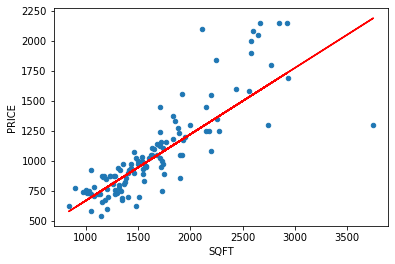

In [116]:
df.plot.scatter(x = 'SQFT', y = 'PRICE')
y1 = []
for i in df['SQFT']:
    y1.append(coef['coef'][0] + i*coef['coef'][1])
plt.plot(df['SQFT'], y1, 'r')
plt.show()

# 2.	Постараться максимально близко восстановить пустые значения (NaN) для переменной AGE. Для этого постройте модель для известных значений PRICE и AGE, найдите коэффициенты и на основе полученной модели заполните пустые значения.

In [192]:
df = pd.read_csv('Albuquerque Home Prices.txt', sep='\t')
df = df.replace(-9999, np.nan)
df['TAX'] = df['TAX'].fillna(df['TAX'].mean())

In [193]:
df_age = df.dropna(axis = 0)
X = df_age.drop('AGE', axis=1)
y = df_age['AGE']
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [194]:
print('R^2 = ', model.score(X, y))
regression_coef(model, X, y)

R^2 =  0.40357365338878237


,predictor,coef,pvalue
0,intercept,21.033788,0.000365
1,PRICE,-0.001287,0.873652
2,SQFT,0.022392,0.000609
3,FEATS,-2.821699,0.012575
4,NE,8.228914,0.004342
5,CUST,2.186168,0.520137
6,COR,-0.443693,0.886666
7,TAX,-0.043687,0.000014


In [195]:
age = model.predict(df.drop('AGE', axis=1))

In [196]:
import math
for i in range(len(df)):
    if math.isnan(df['AGE'][i]):
        df['AGE'][i] = age[i]
df

/Users/grigory/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13.000000,7,1,1,0,1639.0
1,2080,2600,28.175087,4,1,1,0,1088.0
2,2150,2664,6.000000,5,1,1,0,1193.0
3,2150,2921,3.000000,6,1,1,0,1635.0
4,1999,2580,4.000000,4,1,1,0,1732.0
...,...,...,...,...,...,...,...,...
112,872,1229,6.000000,3,0,0,0,721.0
113,870,1273,4.000000,4,0,0,0,638.0
114,869,1165,7.000000,4,0,0,0,694.0
115,766,1200,7.000000,4,0,0,1,634.0


# Повторите все из (1) с учетом восстановленной переменной AGE

In [197]:
X = df.drop('PRICE', axis=1)
y = df['PRICE']
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [198]:
print('R^2 = ', model.score(X, y))
regression_coef(model, X, y)

R^2 =  0.8024129112994897


,predictor,coef,pvalue
0,intercept,97.100927,0.214850
1,SQFT,0.306628,0.000100
2,AGE,-0.665416,0.759389
3,FEATS,10.288714,0.470550
4,NE,13.480395,0.732512
5,CUST,134.355178,0.003417
6,COR,-66.039749,0.117095
7,TAX,0.512409,0.000392


Точность получилась немного лучше, но в целом ситуация не изменилась

In [199]:
df.corr()

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
PRICE,1.000000,0.844795,-0.167766,0.420272,0.167840,0.555292,-0.079293,0.844889
SQFT,0.844795,1.000000,0.006073,0.394925,0.145030,0.520102,0.040528,0.832674
AGE,-0.167766,0.006073,1.000000,-0.342862,0.205578,0.020354,0.082139,-0.347671
FEATS,0.420272,0.394925,-0.342862,1.000000,0.190016,0.241964,-0.041547,0.419473
NE,0.167840,0.145030,0.205578,0.190016,1.000000,0.043033,-0.077336,0.189230
CUST,0.555292,0.520102,0.020354,0.241964,0.043033,1.000000,-0.003994,0.444906
COR,-0.079293,0.040528,0.082139,-0.041547,-0.077336,-0.003994,1.000000,-0.058329
TAX,0.844889,0.832674,-0.347671,0.419473,0.189230,0.444906,-0.058329,1.000000


In [200]:
X = df[['SQFT', 'CUST']]
model.fit(X, y)
print('R^2 = ', model.score(X, y))
regression_coef(model, X, y)

R^2 =  0.7320966420178658


,predictor,coef,pvalue
0,intercept,114.134824,0.082734
1,SQFT,0.553635,0.000000
2,CUST,142.859931,0.005787


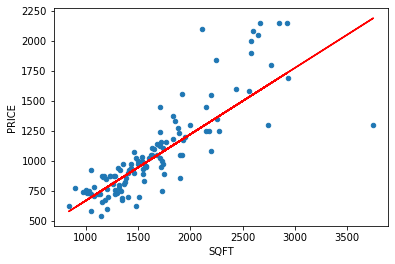

In [201]:
df.plot.scatter(x = 'SQFT', y = 'PRICE')
y1 = []
for i in df['SQFT']:
    y1.append(coef['coef'][0] + i*coef['coef'][1])
plt.plot(df['SQFT'], y1, 'r')
plt.show()

# Предсказание по введенным данным:

In [233]:
a1, a2 = input('Введите данные помещения: площадь, CUST: ').split()
data = pd.DataFrame(columns = ['SQFX', 'CUST'])
data.loc[0] = [a1, a2]
print('Примерная цена дома:', model.predict(data))

Введите данные помещения: площадь, CUST: 2550 1


,SQFX,CUST
0,2550,1


Примерная цена дома: [1668.76507622]


# 3.	Бриллианты. Разобрать все примеры. Построить три модели. Построить графики с линиями регрессий. Объяснить выбор модели.

In [127]:
df = pd.read_csv('diamond.dat', header=None, sep='\s+', names=['weight', 'price'])
df.head()

,weight,price
0,0.17,355
1,0.16,328
2,0.17,350
3,0.18,325
4,0.25,642


In [128]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(
                          # Максимальная степень
                          degree=2,
                          # Не генерировать свободный член
                          include_bias=False)
y = df['price']
X0 = poly.fit_transform(df[['weight']])
X0 = pd.DataFrame(X0, columns=['weight', 'weight^2'])
X0.head()

,weight,weight^2
0,0.17,0.0289
1,0.16,0.0256
2,0.17,0.0289
3,0.18,0.0324
4,0.25,0.0625


In [129]:
X0 = [
    # Одна оригинальная переменная weight
    X0[['weight']],
    # Одна переменная weight^2
    X0[['weight^2']],
    # Две переменных weight и weight^2
    X0.copy()]
models = [LinearRegression() for _ in X0]

In [131]:
for X, model in zip(X0, models):
    model.fit(X, y)
    print(model.score(X, y))

0.978260777986033
0.9703108184171091
0.9789175801893899


In [140]:
coef1 = regression_coef(models[0], X0[0], y)
coef1

,predictor,coef,pvalue
0,intercept,-259.625907,0.0
1,weight,3721.024852,0.0


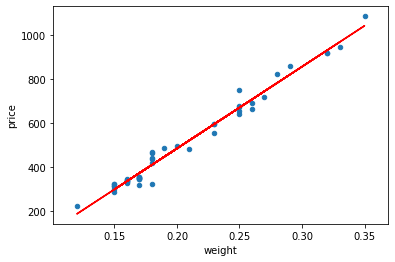

In [160]:
y11 = []
df.plot.scatter(x = 'weight', y = 'price')
for i in df['weight']:
    y11.append(coef1['coef'][0] + i*coef1['coef'][1])
plt.plot(df['weight'], y11, 'r')
plt.show()

In [161]:
coef2 = regression_coef(models[1], X0[1], y)
coef2

,predictor,coef,pvalue
0,intercept,141.659045,0.0
1,weight^2,7993.108083,0.0


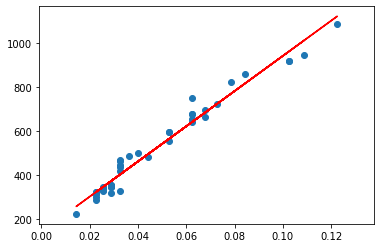

In [168]:
y12 = []
plt.scatter(df['weight']**2, df['price'])
for i in df['weight']:
    y12.append(coef2['coef'][0] + i**2*coef2['coef'][1])
plt.plot(df['weight']**2, y12, 'r')
plt.show()

In [142]:
coef3 = regression_coef(models[2], X0[2], y)
coef3

,predictor,coef,pvalue
0,intercept,-174.130082,0.021866
1,weight,2920.130591,0.000077
2,weight^2,1739.901579,0.237265


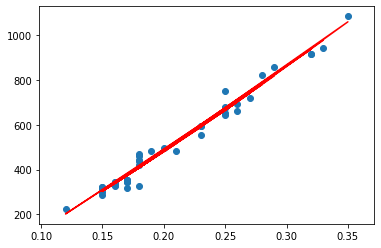

In [170]:
y13 = []
plt.scatter(df['weight'], df['price'])
for i in df['weight']:
    y13.append(coef3['coef'][0] + i*coef3['coef'][1]+i**2*coef3['coef'][2])
plt.plot(df['weight'], y13, 'r')
plt.show()

In [136]:
import statsmodels.api as sm
X2 = sm.add_constant(X0[2])
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1045.
Date:                Sun, 04 Oct 2020   Prob (F-statistic):           1.94e-38
Time:                        23:19:06   Log-Likelihood:                -232.47
No. Observations:                  48   AIC:                             470.9
Df Residuals:                      45   BIC:                             476.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -174.1301     74.238     -2.346      0.0

/Users/grigory/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# 4.	Временные ряды. Разобрать пример. Построить прогноз на следующие 12 месяцев. Вывести предсказанные результаты и результаты за последний (12-й год) в виде чисел.

In [171]:
df = pd.read_csv('series_g.csv', sep=';')
df.head()

,date,series_g
0,JAN 1949,112
1,FEB 1949,118
2,MAR 1949,132
3,APR 1949,129
4,MAY 1949,121


In [172]:
# Преобразуем строчки с датами в объект datetime
# format='%b %Y' означает, что в нашей строчке сначала идёт трёхбуквенное название месяца (%b), а затем год (%Y)
df['date'] = pd.to_datetime(df['date'], format='%b %Y')

Text(0, 0.5, 'log10 от тысяч человек')

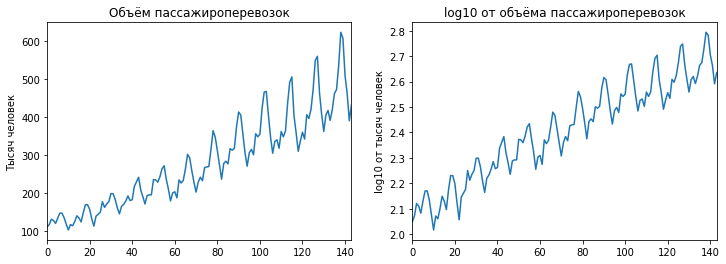

In [173]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
df['series_g'].plot(ax=ax1)
ax1.set_title(u'Объём пассажироперевозок')
ax1.set_ylabel(u'Тысяч человек')

ax2 = fig.add_subplot(122)
pd.Series(np.log10(df['series_g'])).plot(ax=ax2)
ax2.set_title(u'log10 от объёма пассажироперевозок')
ax2.set_ylabel(u'log10 от тысяч человек')



In [174]:
# Создаём последовательсть месяцев. freq='MS' означает первое число каждого месяца из указанного диапазона дат
new_dates = pd.date_range('1961-01-01', '1961-12-01', freq='MS')
# Приводим df['date'] к типу Index, объединяем с 12 месяцами, полученными на предыдущем шаге
new_dates = pd.Index(df['date']) | new_dates
# Создаём датафрейм из одной колонки с расширенным набором дат
df2 = pd.DataFrame({'date': new_dates})
# Объединяем два датафрейма по колонке 'date'.
df = pd.merge(df, df2, on='date', how='right')

In [175]:
df['month_num'] = range(1, len(df) + 1)
df['log_y'] = np.log10(df['series_g'])

In [177]:
for x in range(1, 13):
    df['season_' + str(x)] = df['date'].dt.month == x

In [179]:
# xrange(2, 13) соответствует всем месяцам с февраля по декабрь
season_columns = ['season_' + str(x) for x in range(2, 13)]

# Создадим объекты матрицу X и вектор y для обучения модели
X = df[['month_num'] + season_columns]
y = df['log_y']

# Оставим только те строчки, у которых известны значения y (с номером < 144)
X1 = X[X.index < 144]
y1 = y[y.index < 144]

In [180]:
model = LinearRegression()
model.fit(X1, y1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

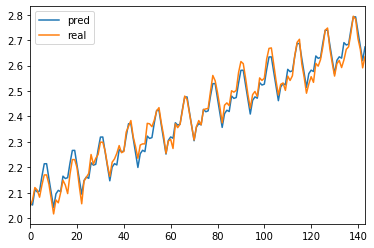

In [181]:
pred = pd.DataFrame({
    'pred': model.predict(X1),
    'real': y1})
pred.plot()

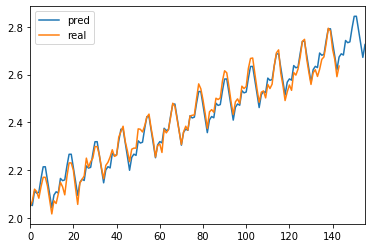

In [182]:
pred = pd.DataFrame({
    'pred': model.predict(X),
    'real': y})
pred.plot()

# Вывести предсказанные результаты и результаты за последний (12-й год) в виде чисел

In [229]:
10**pred['pred'] #все предсказанные данные

0      114.074207
1      112.715073
2      129.691568
3      126.971040
4      127.952000
          ...    
151    698.240208
152    610.328529
153    536.951593
154    469.777436
155    531.760310
Name: pred, Length: 156, dtype: float64

In [230]:
10**pred['pred'][-12:] #последний год

144    486.266611
145    480.473001
146    552.839079
147    541.242225
148    545.423784
149    622.521448
150    697.700003
151    698.240208
152    610.328529
153    536.951593
154    469.777436
155    531.760310
Name: pred, dtype: float64